In [1]:
import numpy as np
import pandas as pd
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [2]:
dftrain = pd.read_csv("https://storage.googleapis.com/tf-datasets/titanic/train.csv")
dftest = pd.read_csv("https://storage.googleapis.com/tf-datasets/titanic/eval.csv")
y_train = dftrain.pop("survived")
y_test = dftest.pop("survived")

In [3]:
import tensorflow as tf
tf.random.set_seed(123)

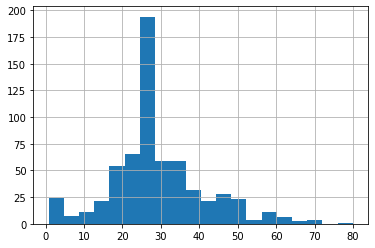

In [4]:
dftrain.age.hist(bins=20)

In [5]:
dftrain.head()

,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,female,35.0,1,0,53.1000,First,C,Southampton,n
4,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


In [4]:
fc = tf.feature_column
CATEGORICAL_COLUMNS = ["sex", "n_siblings_spouses", "parch", "class",
                       "deck", "embark_town", "alone"]
NUMERIC_COLUMNS = ["age", "fare"]

def one_hot_cat_column(feature_name, vocab):
    return tf.feature_column.indicator_column(
        tf.feature_column.categorical_column_with_vocabulary_list(
            feature_name, vocab))

feature_columns = []
for feature_name in CATEGORICAL_COLUMNS:
    vocabulary = dftrain[feature_name].unique()
    feature_columns.append(one_hot_cat_column(feature_name, vocabulary))
    
for feature_name in NUMERIC_COLUMNS:
    feature_columns.append(tf.feature_column.numeric_column(
        feature_name, dtype=tf.float32))

In [5]:
example = dict(dftrain.head(1))
class_fc = tf.feature_column.indicator_column(
    tf.feature_column.categorical_column_with_vocabulary_list(
        "class", ("First", "Second", "Third")))
print("Feature value: {}".format(example['class'].iloc[0]))
print("One hot encoded : {}".format(
    tf.keras.layers.DenseFeatures([class_fc])(example).numpy()))

Feature value: Third
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
One hot encoded : [[0. 0. 1.]]


In [8]:
tf.keras.layers.DenseFeatures(feature_columns)(example).numpy()

array([[22.  ,  1.  ,  0.  ,  1.  ,  0.  ,  0.  ,  1.  ,  0.  ,  0.  ,
         0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  1.  ,  0.  ,  0.  ,  0.  ,
         7.25,  1.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  1.  ,
         0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  1.  ,  0.  ]], dtype=float32)

In [6]:
NUM_EXAMPLES = len(y_train)

def make_input_fn(X, y, n_epochs=None, shuffle=True):
    def input_fn():
        dataset = tf.data.Dataset.from_tensor_slices((dict(X), y))
        if shuffle:
            dataset = dataset.shuffle(NUM_EXAMPLES)
        dataset = dataset.repeat(n_epochs)
        dataset = dataset.batch(NUM_EXAMPLES)
        return dataset
    return input_fn

train_input_fn = make_input_fn(dftrain, y_train)
eval_input_fn = make_input_fn(dftest, y_test, shuffle=False, n_epochs=1)

In [10]:
linear_est = tf.estimator.LinearClassifier(feature_columns)
linear_est.train(train_input_fn, max_steps=100)
result = linear_est.evaluate(eval_input_fn)
clear_output()
print(pd.Series(result))

accuracy                  0.765152
accuracy_baseline         0.625000
auc                       0.832844
auc_precision_recall      0.789631
average_loss              0.478908
label/mean                0.375000
loss                      0.478908
precision                 0.703297
prediction/mean           0.350790
recall                    0.646465
global_step             100.000000
dtype: float64


In [ ]:
n_batches = 1
est = tf.estimator.BoostedTreesClassifier(
    feature_columns, n_batches_per_layer=n_batches)

est.train(train_input_fn, max_steps=100)

result = est.evaluate(eval_input_fn)
clear_output()
print(pd.Series(result))

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpn3i2q3lv', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7efb8d620550>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
Instructions for updating:
If using Keras pass *_constra

In [ ]:
params = {
  'n_trees': 50,
  'max_depth': 3,
  'n_batches_per_layer': 1,
  # You must enable center_bias = True to get DFCs. This will force the model to
  # make an initial prediction before using any features (e.g. use the mean of
  # the training labels for regression or log odds for classification when
  # using cross entropy loss).
  'center_bias': True
}

est = tf.estimator.BoostedTreesClassifier(feature_columns, **params)
# Train model.
est.train(train_input_fn, max_steps=100)

# Evaluation.
results = est.evaluate(eval_input_fn)
clear_output()
pd.Series(results).to_frame()

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpkd02v3_g', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7efb8463dbe0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
Instructions for updating:
If using Keras pass *_constra